# 1. SETUP

## 1.1 Imports


In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from A2C_discrete import A2C
from tqdm import tqdm
import os
%load_ext autoreload
%autoreload 2

## 1.2 PARAMETERS SETUP


In [2]:
# utils functions 
def set_seed(seed):
    torch.manual_seed(seed) # pytorch random seed
    np.random.seed(seed) # numpy random seed

def getTrajectory():
    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", max_episode_steps=500)
    states = []
    # get an initial state
    state, info = env.reset()
    states.append(state)
    done = False
    # play one episode
    done = False
    for i in range(6):
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(0) # only pushes left (0 is left, 1 is right)
        states.append(state)
    while not done:
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(1) # only pushes left (0 is left, 1 is right)
        states.append(state)
        done = terminated or truncated
        
    env.close()
    return states

# HYPERPARAMETERS
# environment hyperparams
n_steps = 101000
n_envs = 1
n_steps_per_update = 1
n_updates = n_steps // (n_steps_per_update*n_envs)
evaluation_interval = 20000//(n_steps_per_update*n_envs) # evaluate the agent every 20k steps
n_eval_runs = 10 # how many evaluation runs to do each 20k steps 
n_evaluations = n_updates // evaluation_interval

# Aggregate parameters
n_seeds = 3 # number of random seeds for the aggregation of plots
agents_seeds = [10, 42, 81] # Arbitrary seeds for the agents

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3
stochasticity_bool = False
stochastic_reward_probability = 0.9
# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# SEED
# Set a seed value
seed_value = 50
set_seed(seed_value)

# ENVIRONMENT
env = gym.make("CartPole-v1")
env_eval = gym.make("CartPole-v1")
obs_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

# DEVICE
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device: ", device)

# AGENT
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

Device:  cpu


# 2. AGENT TRAINING

In [3]:
# LOGGED VARIABLES
critic_losses = np.zeros((n_updates+1, n_seeds))
actor_losses = np.zeros((n_updates+1, n_seeds))
entropies = np.zeros((n_updates+1, n_seeds))
episode_returns = [[] for _ in range(n_seeds)] # logs the returns of the agent in each episode
steps_episodes = [[] for _ in range(n_seeds)] # logs the steps taken of the agent in each episode
evaluation_returns = [[] for _ in range(n_seeds)] # logs the returns of the agent during evaluation
values = [[] for _ in range(n_seeds)] # logs the values of the agent on the fixed trajectory

fixed_trajectory = getTrajectory()

# Running for the n_seeds agents 
for s, agent_seed in enumerate(agents_seeds):
    print(f"Running seed {agent_seed} for agent {s}")
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)
    # COUNTERS
    steps = 0
    ep_counter = 0
    ep_reward = 0

    # VARIABLE INITIALIZATION
    is_truncated = False
    is_terminated = False
    states, info = env.reset(seed=agent_seed) #only use the seed when resetting the first time
    set_seed(agent_seed)
    
    #values = np.array(n_evaluations,len(fixed_trajectory)) # log the values over a trajectory

    # use tqdm to get a progress bar for training
    for steps in tqdm(range(n_updates+1)):
            

        # reset lists that collect experiences of a n_steps_per_update
        n_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        n_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
        # don't take mask and reward gradient
        masks = torch.ones(n_steps_per_update, n_envs, device=device,requires_grad = False)
        n_rewards = torch.zeros(n_steps_per_update, n_envs, device=device,requires_grad = False)
        end_states = []
        end_states_idx = [0]

        # play n_steps_per_update to collect data
        for step in range(n_steps_per_update):
            # select an action A_{t} using S_{t} as input for the agent, get actions and values Vt
            actions, action_log_probs, V_t, entropy = agent.select_action(states, bool_greedy=False)

            # ensure no grad is taken in the step
            with torch.no_grad():
                states, reward, is_terminated, is_truncated, infos = env.step(
                    actions.cpu().numpy()
                )

            if stochasticity_bool:
                # introduce stochasticity in the reward
                if np.random.rand() < stochastic_reward_probability:
                    reward = 0

            ep_reward += reward # increase episode return
            mask = not is_terminated # define mask for bootstrapping

            # log the value, reward and action log prob of the last step
            n_value_preds[step] = torch.squeeze(V_t)
            n_rewards[step] = torch.tensor(reward, device=device)
            n_action_log_probs[step] = action_log_probs

            # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
            masks[step] = torch.tensor(mask) # allows for correct bootstrapping
            
            # reset environment if truncated or terminated
            if is_terminated or is_truncated:
                states_tensor = torch.tensor(states, device=device) # Transform the last state reached (S_t+n) to a tensor
                end_states.append(states_tensor)
                end_states_idx.append(step)
                states, info = env.reset() # do not use the seed when resetting again
                ep_counter += 1
                steps_episodes[s].append(steps)
                episode_returns[s].append(ep_reward)
                ep_reward = 0

        
        # if statement to make sure we don't append the end state twice
        if not is_terminated and not is_truncated:
            states_tensor = torch.tensor(states, device=device) # Transform the last state reached (S_t+n) to a tensor
            end_states.append(states_tensor)
            end_states_idx.append(step)
        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            n_rewards,
            n_action_log_probs,
            n_value_preds,
            entropy,
            masks,
            gamma,
            end_states,
            end_states_idx
        )

        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)

        # log the losses and entropy
        critic_losses[steps, s] = critic_loss.detach().cpu().numpy()
        actor_losses[steps, s] = actor_loss.detach().cpu().numpy()
        entropies[steps, s] = entropy.detach().mean().cpu().numpy()

        #After every 20k steps, evaluate the performance of your agent by running it for 10 episodes with a greedy action policy (without noise)
        #on a newly initialized environment and plotting the evaluation statistics below.
        with torch.no_grad(): # No need to store gradients in the evaluation
            if steps % evaluation_interval == 0:
                print("EVALUATION")
                # evaluate
                returns = []
                episode_lengths = []
                for i in range(n_eval_runs):
                    # Only use the seed when resetting at the beginning to ensure the states will follow the same initialization at every evalutaion step
                    if i == 0:
                        state, info = env_eval.reset(seed = agent_seed)
                        value = []
                        for state_traj in fixed_trajectory:
                            _, _, V_t, _ = agent.select_action(state_traj, bool_greedy=False)
                            value.append(V_t)
                        values[s].append(value)
                    else:
                        state, info = env_eval.reset()
                    episode_return = 0
                    episode_length = 0
                    while True:
                        action, _, _, _ = agent.select_action(state,bool_greedy=True)
                        state, reward, terminated, truncated, info = env_eval.step(action.cpu().numpy())
                        episode_return += reward
                        episode_length += 1
                        if terminated or truncated:
                            break
                    returns.append(episode_return)
                    episode_lengths.append(episode_length)  
                print(returns)
                evaluation_returns[s].append(np.mean(returns))





Running seed 10 for agent 0


  0%|          | 0/101001 [00:00<?, ?it/s]/Users/alexis/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 43/101001 [00:00<03:55, 428.44it/s]

EVALUATION
[54.0, 60.0, 63.0, 89.0, 35.0, 40.0, 36.0, 33.0, 34.0, 39.0]


 20%|█▉        | 20048/101001 [00:15<01:26, 931.53it/s] 

EVALUATION
[169.0, 136.0, 362.0, 139.0, 91.0, 113.0, 119.0, 105.0, 224.0, 108.0]


 39%|███▉      | 39872/101001 [00:30<00:45, 1357.86it/s]

EVALUATION


 40%|███▉      | 40146/101001 [00:30<01:20, 752.73it/s] 

[334.0, 431.0, 386.0, 432.0, 500.0, 458.0, 446.0, 500.0, 458.0, 500.0]


 59%|█████▉    | 59880/101001 [00:46<00:33, 1239.67it/s]

EVALUATION


 60%|█████▉    | 60125/101001 [00:46<01:03, 642.86it/s] 

[402.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 79%|███████▉  | 79874/101001 [01:01<00:16, 1294.32it/s]

EVALUATION


 79%|███████▉  | 80133/101001 [01:02<00:31, 657.99it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 99%|█████████▉| 99903/101001 [01:17<00:00, 1222.39it/s]

EVALUATION


 99%|█████████▉| 100161/101001 [01:18<00:01, 664.31it/s]

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


100%|██████████| 101001/101001 [01:19<00:00, 1277.17it/s]


Running seed 42 for agent 1


  0%|          | 117/101001 [00:00<01:26, 1166.90it/s]

EVALUATION
[10.0, 10.0, 9.0, 9.0, 10.0, 11.0, 9.0, 10.0, 9.0, 9.0]


 20%|█▉        | 19885/101001 [00:14<00:59, 1370.27it/s]

EVALUATION


 20%|█▉        | 20160/101001 [00:15<01:30, 891.30it/s] 

[261.0, 350.0, 245.0, 500.0, 288.0, 182.0, 315.0, 252.0, 263.0, 163.0]


 40%|███▉      | 39906/101001 [00:30<00:44, 1381.55it/s]

EVALUATION


 40%|███▉      | 40182/101001 [00:30<01:25, 713.94it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 59%|█████▉    | 59878/101001 [00:45<00:29, 1377.03it/s]

EVALUATION


 60%|█████▉    | 60152/101001 [00:45<00:57, 711.18it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 79%|███████▉  | 79915/101001 [01:00<00:15, 1372.52it/s]

EVALUATION


 79%|███████▉  | 80189/101001 [01:01<00:29, 708.95it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 99%|█████████▉| 99875/101001 [01:15<00:00, 1312.94it/s]

EVALUATION


 99%|█████████▉| 100138/101001 [01:16<00:01, 665.36it/s]

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


100%|██████████| 101001/101001 [01:17<00:00, 1310.06it/s]


Running seed 81 for agent 2


  0%|          | 117/101001 [00:00<01:26, 1165.15it/s]

EVALUATION
[8.0, 10.0, 8.0, 10.0, 10.0, 10.0, 8.0, 9.0, 10.0, 10.0]


 20%|█▉        | 20023/101001 [00:16<01:32, 873.94it/s] 

EVALUATION
[217.0, 165.0, 211.0, 150.0, 208.0, 146.0, 285.0, 186.0, 160.0, 150.0]


 40%|███▉      | 39999/101001 [00:31<00:44, 1359.25it/s]

EVALUATION


 40%|███▉      | 40272/101001 [00:31<01:14, 813.00it/s] 

[293.0, 352.0, 326.0, 403.0, 351.0, 500.0, 250.0, 297.0, 346.0, 360.0]


 59%|█████▉    | 59933/101001 [00:46<00:30, 1354.34it/s]

EVALUATION


 60%|█████▉    | 60200/101001 [00:47<01:00, 679.91it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


 79%|███████▉  | 79883/101001 [01:02<00:15, 1345.59it/s]

EVALUATION


 79%|███████▉  | 80147/101001 [01:02<00:30, 684.45it/s] 

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 455.0, 500.0, 500.0, 500.0]


 99%|█████████▉| 99913/101001 [01:17<00:00, 1353.67it/s]

EVALUATION


 99%|█████████▉| 100177/101001 [01:18<00:01, 684.08it/s]

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]


100%|██████████| 101001/101001 [01:18<00:00, 1279.04it/s]


# 3. RESULTS

In [20]:
# Trying to aggregate the episode returns of different lengths ==> Can be deleted in case
array_of_objects = np.array(episode_returns, dtype=object)
print(array_of_objects.shape)
for i in range(3):
    print(len(array_of_objects[i]))
print(episode_returns[0])


(3,)
618
676
599
[14.0, 48.0, 12.0, 12.0, 15.0, 29.0, 14.0, 38.0, 45.0, 28.0, 11.0, 61.0, 10.0, 58.0, 17.0, 17.0, 31.0, 40.0, 15.0, 18.0, 12.0, 39.0, 15.0, 18.0, 24.0, 72.0, 38.0, 12.0, 21.0, 11.0, 22.0, 27.0, 22.0, 45.0, 19.0, 34.0, 24.0, 14.0, 21.0, 13.0, 20.0, 24.0, 89.0, 19.0, 35.0, 35.0, 42.0, 80.0, 20.0, 13.0, 60.0, 18.0, 21.0, 41.0, 64.0, 38.0, 23.0, 28.0, 12.0, 23.0, 27.0, 41.0, 26.0, 16.0, 27.0, 36.0, 17.0, 18.0, 30.0, 17.0, 41.0, 16.0, 15.0, 36.0, 17.0, 20.0, 21.0, 22.0, 12.0, 19.0, 99.0, 21.0, 67.0, 22.0, 20.0, 29.0, 14.0, 39.0, 23.0, 43.0, 69.0, 16.0, 20.0, 34.0, 17.0, 54.0, 60.0, 25.0, 18.0, 29.0, 28.0, 25.0, 59.0, 55.0, 24.0, 21.0, 18.0, 18.0, 61.0, 25.0, 46.0, 45.0, 73.0, 33.0, 21.0, 40.0, 73.0, 34.0, 32.0, 52.0, 42.0, 24.0, 41.0, 12.0, 26.0, 42.0, 22.0, 45.0, 17.0, 33.0, 51.0, 41.0, 23.0, 69.0, 21.0, 65.0, 44.0, 66.0, 34.0, 14.0, 40.0, 98.0, 20.0, 50.0, 25.0, 54.0, 48.0, 32.0, 26.0, 27.0, 18.0, 89.0, 46.0, 22.0, 75.0, 23.0, 144.0, 28.0, 25.0, 33.0, 57.0, 54.0, 78.0, 71.

## 3.1 PLOTTING

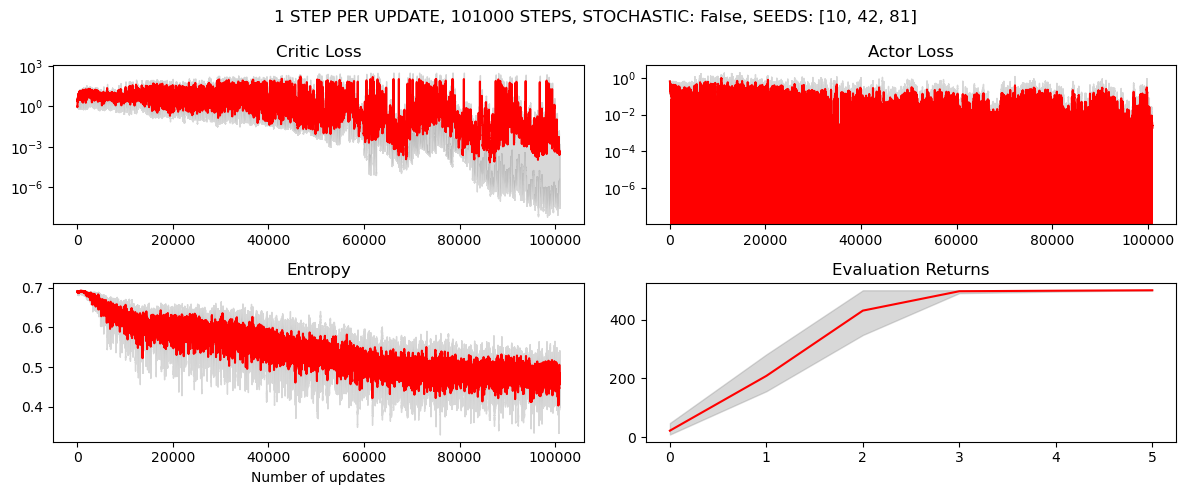

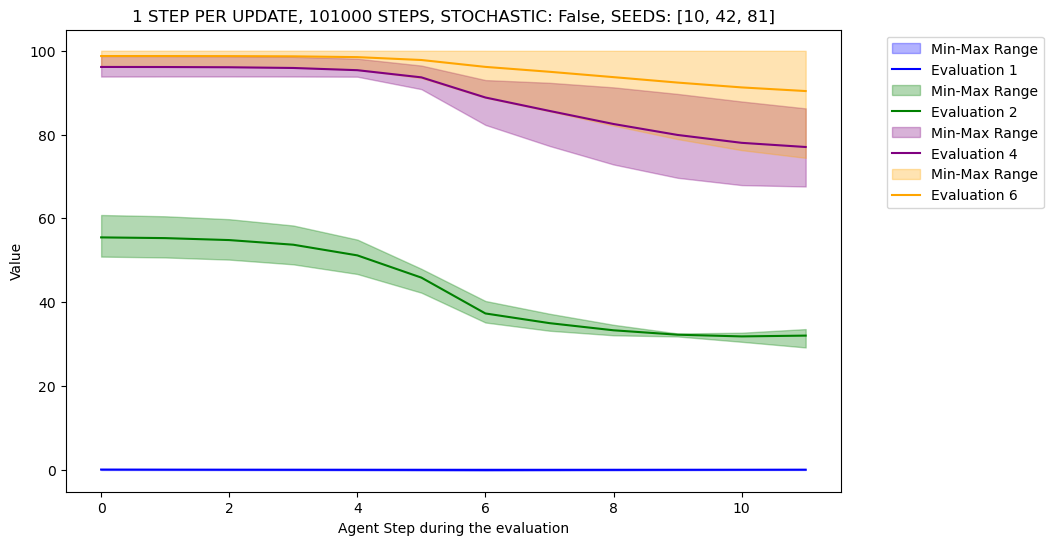

In [29]:
# alternative: use SummaryWriter from torch.utils.tensorboard
def aggregate_plot(y1,y2,y3):

    # Compute minimum and maximum curves
    y_min = np.minimum(np.minimum(y1, y2), y3)
    y_max = np.maximum(np.maximum(y1, y2), y3)

    # Compute average curve
    y_avg = (y1 + y2 + y3) / 3

    return y_min, y_max, y_avg

rolling_length = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(f"{n_steps_per_update} STEP PER UPDATE, {n_steps} STEPS, STOCHASTIC: {stochasticity_bool}, SEEDS: {agents_seeds}")

# For the value function trajectories
values_arr = np.array(values) # Transforming the list to a numpy array ==> Values_arr of size (n_seeds, n_eval_done, steps_in_trajectory, 1)
values_sq = np.squeeze(values_arr) # Now of size (n_seeds, n_eval_done, steps_in_trajectory)
n_eval_done = values_sq.shape[1] # Number of evaluations done 
steps_in_trajectory = values_sq.shape[2] # Amount of steps in the trajectories of the value function
n_traj = 4 # Amount of value function trajectories to be plotted


# The code below is to select n_traj evenly spaced trajectories to plot between the first and last evaluation
if n_eval_done >= n_traj:
    idx_traj = np.linspace(0, n_eval_done - 1, n_traj, dtype='int') # Selecting n_traj trajectories evenly spaced between the first and last
else:
    idx_traj = np.arange(n_eval_done) # in case there are less evaluations than trajectories to plot, plot all evaluations

n_traj = len(idx_traj) # No matter how many trajectories where found, n_traj is updated to the actual length of the idx_traj
val_array = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Array to store the values of the selected trajectories
val_array = values_sq[:,idx_traj] # of size n_seeds, n_traj, steps_in_trajectory => contains only the values of the selected trajectories

traj_aggregates = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Will receive the values of y_min, y_max and y_avg for each of the n_traj for each seed


# Creating the lists for the aggregation
critic_y =[[] for _ in range(n_seeds)]
actor_y =[[] for _ in range(n_seeds)]
entropy_y =[[] for _ in range(n_seeds)]
eval_returns_arr = np.array(evaluation_returns)
#ep_returns_arr = np.array(episode_returns)

for s, agent_seed in enumerate(agents_seeds):
    critic_y[s] = (
        np.convolve(np.array(critic_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    actor_y[s] = (
        np.convolve(np.array(actor_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    entropy_y[s] = (
        np.convolve(np.array(entropies[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    
# Building the y_min, y_max and y_avg for each of the plots
critic_y_min, critic_y_max, critic_y_avg = aggregate_plot(critic_y[0],critic_y[1],critic_y[2])
actor_y_min, actor_y_max, actor_y_avg = aggregate_plot(actor_y[0],actor_y[1],actor_y[2])
entropy_y_min, entropy_y_max, entropy_y_avg = aggregate_plot(entropy_y[0],entropy_y[1],entropy_y[2])
eval_reward_y_min, eval_reward_y_max, eval_reward_y_avg = aggregate_plot(eval_returns_arr[0], eval_returns_arr[1], eval_returns_arr[2])
#ep_return_y_min, ep_return_y_max, ep_return_y_avg = aggregate_plot(ep_returns_arr[0], ep_returns_arr[1], ep_returns_arr[2])

# x values for the plots
critic_x = np.arange(0, critic_y_min.shape[0])
actor_x = np.arange(0, actor_y_min.shape[0]) # Not necessary
entropy_x = np.arange(0, entropy_y_min.shape[0]) # Not necessary
reward_x = np.arange(0, eval_reward_y_min.shape[0])
traj_x = np.arange(0, steps_in_trajectory)
#ep_return_x = np.arange(0, ep_return_y_min.shape[0])
for j in range(n_traj): # Storing the y_min, y_max and y_avg of each of the n_traj trajectories
    traj_aggregates[0,j], traj_aggregates[1,j], traj_aggregates[2,j], = aggregate_plot(val_array[0][j], val_array[1][j], val_array[2][j])

# Critic loss
axs[0, 0].fill_between(critic_x,critic_y_min, critic_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 0].plot(critic_x, critic_y_avg, color='red', label='Average Curve')
axs[0, 0].set_title('Critic Loss')
axs[0, 0].set_yscale('log')  # Set log scale for the y-axis

# Actor loss
axs[0, 1].fill_between(actor_x,actor_y_min, actor_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 1].plot(actor_x, actor_y_avg, color='red', label='Average Curve')
axs[0, 1].set_title('Actor Loss')
axs[0, 1].set_yscale('log')  # Set log scale for the y-axis

# Entropy
axs[1, 0].fill_between(entropy_x,entropy_y_min, entropy_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 0].plot(entropy_x, entropy_y_avg, color='red', label='Average Curve')
axs[1, 0].set_title("Entropy")
axs[1, 0].set_xlabel("Number of updates")

# Evaluation rewards
axs[1, 1].fill_between(reward_x,eval_reward_y_min, eval_reward_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 1].plot(reward_x, eval_reward_y_avg, color='red', label='Average Curve')
axs[1, 1].set_title('Evaluation Returns')

plt.tight_layout()
plt.show()

"""New plot for the trajectories"""

# Value trajectories
colors = ['blue', 'green', 'purple', 'orange', 'black', 'yellow', 'pink', 'brown', 'cyan', 'magenta']

plt.figure(figsize=(10, 6))

for j in range(len(idx_traj)):
    plt.fill_between(traj_x, traj_aggregates[0,j], traj_aggregates[1,j], color = colors[j], alpha=0.3, label='Min-Max Range')
    plt.plot(traj_x, traj_aggregates[2,j,:], color=colors[j], label=f"Evaluation {idx_traj[j]+1}")

plt.title(f"{n_steps_per_update} STEP PER UPDATE, {n_steps} STEPS, STOCHASTIC: {stochasticity_bool}, SEEDS: {agents_seeds}")
plt.xlabel('Agent Step during the evaluation')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
#plt.savefig(f'figures/{n_steps_per_update}setps_step_stoch_seed{seed_value}.png', bbox_inches='tight')


# Episode returns
# axs[2, 1].fill_between(ep_return_x,ep_return_y_min, ep_return_y_max, color='gray', alpha=0.3, label='Min-Max Range')
# axs[2, 1].plot(ep_return_x, ep_return_y_avg, color='red', label='Average Curve')
# axs[2, 1].set_title('Episode Returns')


# Adjust layout
#plt.tight_layout()
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Show plot
#plt.show()


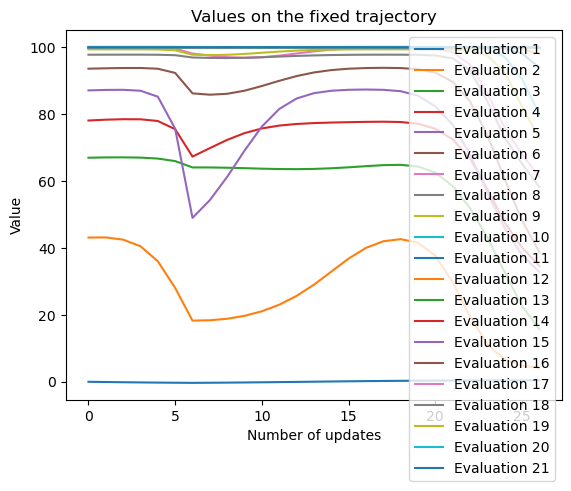

In [29]:
# plot the values of the agent on the fixed trajectory
values = np.array(values)
values = np.squeeze(values)

for i in range(values.shape[0]):
    plt.plot(values[i], label=f"Evaluation {i+1}")

plt.title('Values on the fixed trajectory')
plt.xlabel('Number of updates')
plt.ylabel('Value')
plt.legend()
plt.show()


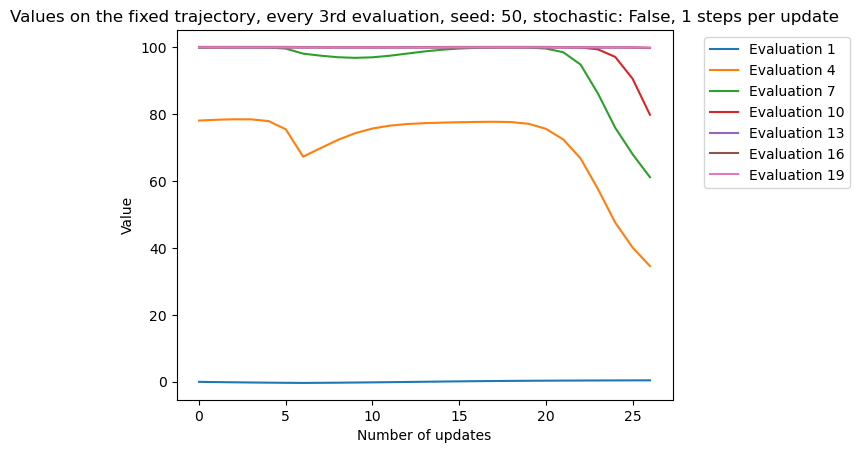

<Figure size 640x480 with 0 Axes>

In [38]:
values = np.array(values)
values = np.squeeze(values)

for i in range(0, values.shape[0], 3):
    plt.plot(values[i], label=f"Evaluation {i+1}")

plt.title(f'Values on the fixed trajectory, every 3rd evaluation, seed: {seed_value}, stochastic: {stochasticity_bool}, {n_steps_per_update} steps per update')
plt.xlabel('Number of updates')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
plt.savefig(f'figures/{n_steps_per_update}setps_step_stoch_seed{seed_value}.png', bbox_inches='tight')



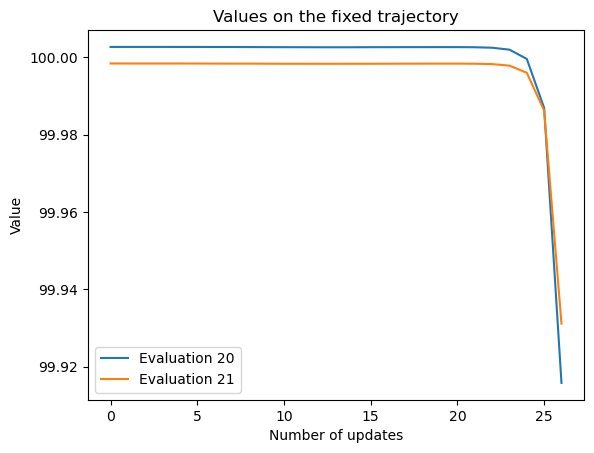

In [32]:
values = np.array(values)
values = np.squeeze(values)

for i in range(values.shape[0]-2, values.shape[0],1):
    plt.plot(values[i], label=f"Evaluation {i+1}")

plt.title('Values on the fixed trajectory')
plt.xlabel('Number of updates')
plt.ylabel('Value')
plt.legend()
plt.show()

In [12]:
values = np.array(values)
values.shape

(11, 9)

In [ ]:
plt.plot(steps_episodes,episode_returns)
plt.title("episode returns")
plt.xlabel("Number of evaluations")
plt.ylabel("Return")
plt.show()

## 3.2 SAVE PLOTS

In [33]:
#save the plot
if stochasticity_bool:
    fig.savefig(f"figures/A2C_{n_steps_per_update}step_stoch_seed{seed_value}_full.png")
else:
    fig.savefig(f"figures/A2C_{n_steps_per_update}step_nostoch_seed{seed_value}_full.png")

## 3.3 SAVE/LOAD AGENT WEIGHTS

In [6]:
save_weights = True
load_weights = False

actor_weights_path = "weights/actor_weights_stoch.h5"
critic_weights_path = "weights/critic_weights_stoch.h5"

if not os.path.exists("weights"):
    os.mkdir("weights")

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)


""" load network weights """
if load_weights:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, 1)

    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval()

## 3.4 SHOWCASE AGENT

In [10]:
n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")

    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=500)

    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None, :], bool_greedy=True)

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.item())

        # update if the environment is done
        done = terminated or truncated

env.close()

starting episode 0...


/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


starting episode 1...
starting episode 2...


: 